# **Algoritmo di Grover**

È un algoritmo di ricerca quantistico, che permette di trovare una delle soluzioni che verificano un oracolo, con complessità

$$
O(\sqrt{n})
$$

Applicato su una QRAM, questo è un vero e proprio algoritmo di ricerca in un database disordinato.

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from BoredQiskit import FastQiskit as fq
from BoredQiskit import FastOracles as fo
from BoredQiskit.FastUtilsGate import int_to_bin
import numpy as np

### **Operatore di Diffusione**

$$
Ref_{|+\rangle}^{\otimes n} = H^{\otimes n} Ref_{|0\rangle}^{\otimes n} H^{\otimes n}
$$

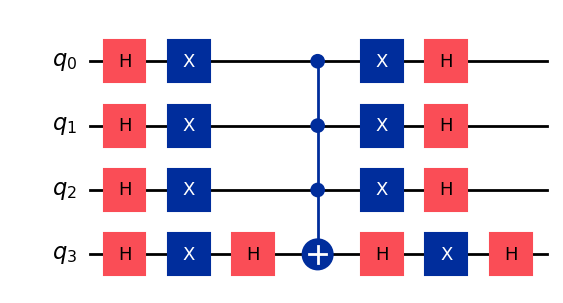

In [9]:
def grover_operator(n: int):
    '''
    builds the diffusion operator from the grover algorithm
    '''
    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)
    
    qc.h(qx)
    qc.x(qx)
    qc.h(qx[n-1])
    qc.mcx(qx[list(range(n-1))], qx[n-1])
    qc.h(qx[n-1])
    qc.x(qx)
    qc.h(qx)

    return qc.to_gate(label='DIFFUSION')

qc = QuantumCircuit(4)
qc = qc.compose(grover_operator(4)).decompose()

qc.draw('mpl')

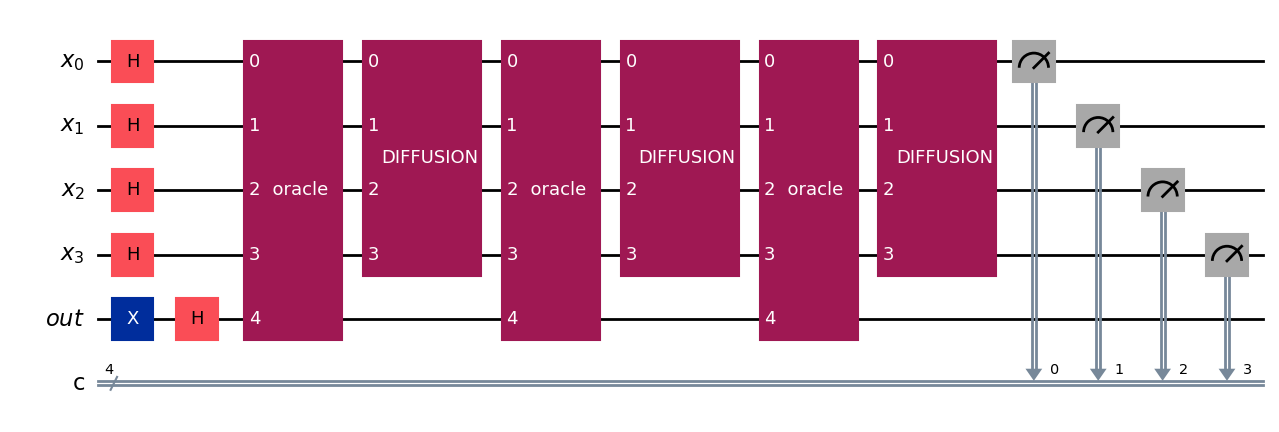

In [10]:
def grover_algorithm(U, n, M=1):
    N = 2**n
    epochs = int(np.floor(np.pi/4 * np.sqrt(N/M)))
    xr = QuantumRegister(n, 'x')
    out = QuantumRegister(1, 'out')
    c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(xr, out, c)
    G = grover_operator(n)

    qc.h(xr)
    qc.x(out)
    qc.h(out)

    for i in range(epochs):
        qc = qc.compose(U, [*xr, out])
        qc = qc.compose(G, xr)

    qc.measure(xr, c)
    return qc

U = fo.general_boolean_oracle(4, ['0101'])
qc = grover_algorithm(U, 4)
qc.draw('mpl')

In [11]:
fq.run(qc)

{'0101': 1,
 '1010': 981,
 '0000': 5,
 '0100': 3,
 '1101': 2,
 '0010': 5,
 '0110': 3,
 '1111': 5,
 '1110': 3,
 '1100': 3,
 '0111': 4,
 '0001': 5,
 '1000': 2,
 '1011': 1,
 '1001': 1}

## **Grover per la ricerca in una QRAM**

In [59]:
def QuantumRAM(v: list[int], barriers=False):
    n = len(v)
    d = int(np.ceil(np.log2(max(v))))
    m = int(np.ceil((np.log2(n))))
    
    ir = QuantumRegister(m, 'i')
    er = QuantumRegister(d, 'out')
    qc = QuantumCircuit(ir,er)

    for j in range(n):
        j_bin = int_to_bin(j, m)
        e_bin = int_to_bin(v[j], d)
        
        if int(e_bin) == 0:
            continue

        for p in [h for h in range(m) if j_bin[h]=='0']:
            qc.x(ir[m-1-p])

        for p in [h for h in range(d) if e_bin[h]=='1']:
            qc.mcx(ir, er[d-1-p])
            
        for p in [h for h in range(m) if j_bin[h]=='0']:
            qc.x(ir[m-1-p])
        if barriers:
            qc.barrier()
    return qc


def QRAM_gate(v:list[int]):
    qc = QuantumRAM(v)
    
    qram_name = "QRAM"
    return qc.to_gate(label=qram_name)


In [174]:
def is_equal_oracle(n: int):
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    a = QuantumRegister(1, 'a')
    
    qc = QuantumCircuit(qx, qy, a)

    for i in range(n):
        qc.cx(qx[i], qy[i])
        
    qc.x(qy)
    qc.mcx([*qy], a)
    qc.x(qy)

    for i in range(n):
        qc.cx(qx[i], qy[i])

    return qc.to_gate(label=' is equal ')

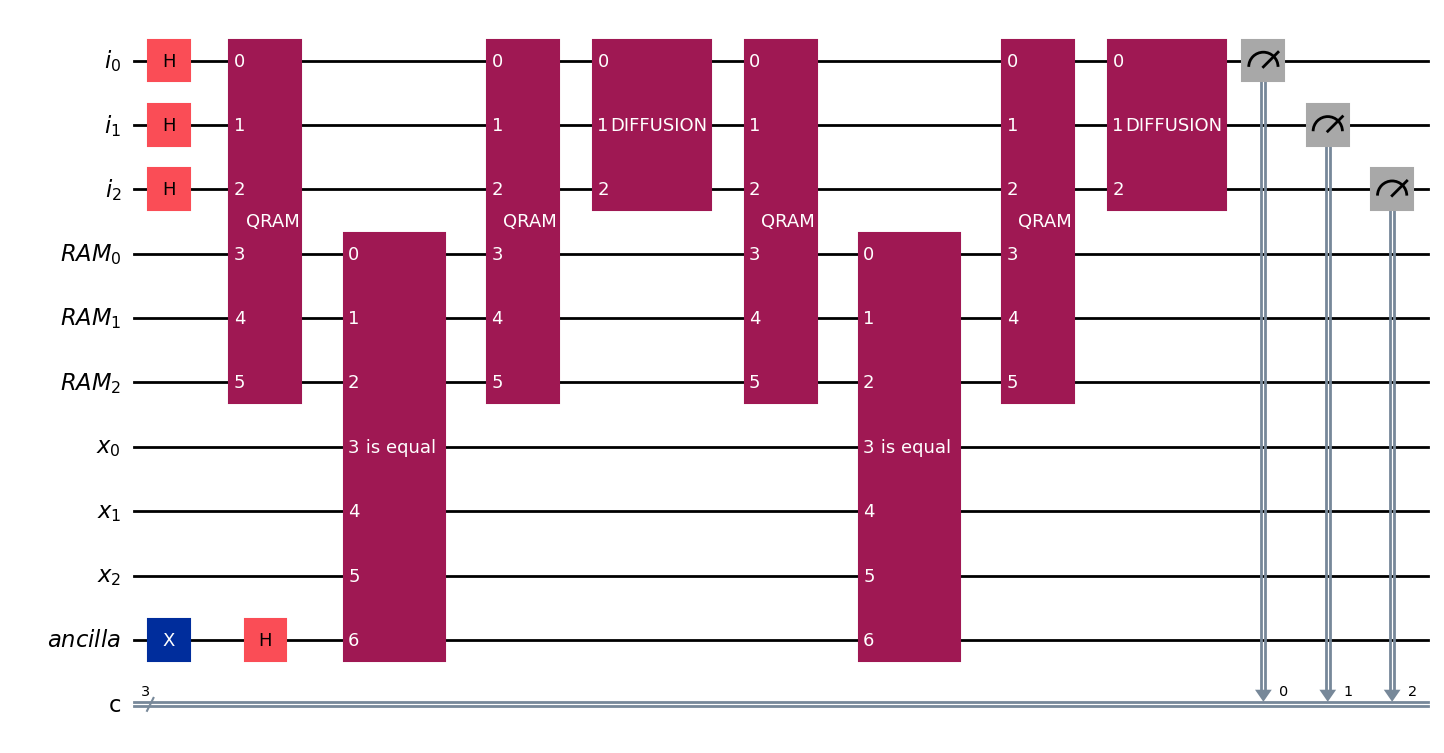

In [176]:
N = 3
V = [5,7,4,3,1,2,0,1]
x = 3
l = 3
qi = QuantumRegister(N, 'i')
qr = QuantumRegister(l, 'RAM')
a = QuantumRegister(1, 'ancilla')
qx = QuantumRegister(l, 'x')
c = ClassicalRegister(3, 'c')

qc = QuantumCircuit(qi, qr, qx, a, c)

qc.x(a)
qc.h(a)
qc.h(qi)

qc = qc.compose(QRAM_gate(V), [*qi, *qr])

qc = qc.compose(is_equal_oracle(l), [*qr, *qx, a])

qc = qc.compose(QRAM_gate(V), [*qi, *qr])

qc = qc.compose(grover_operator(3), qi)

qc = qc.compose(QRAM_gate(V), [*qi, *qr])

qc = qc.compose(is_equal_oracle(l), [*qr, *qx, a])

qc = qc.compose(QRAM_gate(V), [*qi, *qr])

qc = qc.compose(grover_operator(3), qi)


qc.measure(qi, c)
qc.draw('mpl')

In [179]:
fq.run(qc)

{'110': 960,
 '101': 7,
 '100': 5,
 '011': 10,
 '000': 12,
 '001': 12,
 '010': 8,
 '111': 10}